<a href="https://colab.research.google.com/github/spps-supalerk/CategorizationUsingUniversalSentenceEncoder/blob/main/CategorizationUsingUniversalSentenceEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Code

## Import library

In [ ]:
# main library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

# display thai language in colab : https://www.facebook.com/groups/colab.thailand/permalink/1421960354645985/
import matplotlib as mpl
plt.rcParams['font.family'] = 'tahoma'
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New', size=10)


# package for downloading file from Google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# authenticate and create the PyDrive client.
# this only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# download temp file
file_id = '1mkGRWGAFzixktIdVACMEh_qzGmwHNe7o'
f_dir = 'Customer_Behaviors.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(f_dir)

## Read and Clean

In [ ]:
replace_lst = ['content', 'และ', 'and', '/', 'เช่น']
def split_text(x, replace_lst = replace_lst):
  x = x.lower()
  x = re.sub(r'\((.+)\)', '', x)
  for w in replace_lst:
    x = x.replace(w, '')
  if ',' in x:
    x = x.replace(' ','')
    lst_text = x.split(',')
  else:
    lst_text = x.split(' ')
  return lst_text

In [ ]:
df_cb = pd.read_csv('/content/Customer_Behaviors.csv')
df_cb.rename(columns = {'นอกเหนือจากรายการดังกล่าวแล้ว คุณมีความสนใจในเรื่องใดอีกบ้าง':'other_interest'} , inplace=True)

# apply split_text function
other_interest = df_cb['other_interest'].apply(split_text).explode().reset_index()

# ignore punctuation
other_interest = other_interest[other_interest['other_interest'].apply(len)>=2]
other_interest.head(10)

,index,other_interest
0,0,กีฬาufc
1,0,soccer
2,1,กีฬา
3,1,สัตว์เลี้ยง
4,1,เทคโนโลยี
6,3,โหราศาสตร์
7,3,ดูดวง
8,4,สัตว์เลี้ยง
9,5,ด้านการออมเงินวางแผนการใช้เงิน
10,6,อุปกรณ์ไอที


## Download and Install Pre-trained USE

In [ ]:
%tensorflow_version 2.x
!pip install tensorflow_text
import tensorflow_hub as hub
import tensorflow_text
import tensorflow as tf

# download open subtitle EN-TH dataset
!wget http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-th.txt.zip
!unzip download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip -d data

--2021-01-21 10:09:23--  http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/moses/en-th.txt.zip
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-th.txt.zip [following]
--2021-01-21 10:09:24--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-th.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119520928 (114M) [application/zip]
Saving to: ‘download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip.2’

download.php?f=Open 100%[===================>] 113.98M  55.6MB/s    in 2.1s    

2021-01-21 10:09:26 (55.6 MB/s) - ‘download.php?f=OpenSubtitles%2Fv2018%2Fmoses%2Fen-th.txt.zip.2’ saved [119520

In [ ]:
# create USE embedding by using tensorflow hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

## Encode / Embed other_interest (main df)

In [ ]:
emb_other_interest = embed(other_interest['other_interest'].values).numpy()
df_emb_oth_interest = pd.DataFrame(
                                    emb_other_interest,
                                    index = other_interest['other_interest'].values
                                  )
# df_emb_oth_interest['type'] = 'original'
df_emb_oth_interest.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
กีฬาufc,0.106929,-0.040677,0.039707,-0.050232,-0.011018,0.026707,0.061621,-0.032751,-0.037130,-0.019983,0.041342,-0.022466,-0.072359,0.008045,0.038108,0.020356,-0.036452,0.034335,0.041557,0.059720,0.028891,0.069184,0.029928,0.002577,-0.022055,0.041563,0.013456,-0.019306,-0.015649,-0.032495,0.005222,0.010471,-0.013591,-0.033576,0.063754,0.003958,0.048139,0.081499,-0.007863,0.076855,...,0.107795,0.053800,0.054311,0.052866,-0.064976,-0.003409,0.014319,0.015612,-0.039938,0.037555,0.016003,0.009080,-0.010312,-0.032720,0.006448,-0.069425,0.049810,-0.002707,0.004867,-0.094720,0.075873,-0.049080,-0.073486,-0.062489,-0.033022,-0.026894,0.025211,-0.061934,0.043955,-0.079497,-0.069697,0.052950,0.032700,-0.027623,0.033096,0.026848,0.056534,0.039456,-0.031547,0.037660
soccer,0.087659,0.029007,0.035582,0.008142,-0.033767,0.012876,0.039586,-0.006629,0.001187,0.023257,-0.021101,-0.040725,-0.070640,0.050090,0.038158,-0.048656,0.039810,0.001934,0.034671,0.060569,0.017075,0.085736,-0.050497,-0.014436,-0.044594,-0.011939,0.050371,0.047203,0.004612,-0.007791,0.011378,0.058004,0.042525,-0.079519,0.082394,-0.032396,0.018687,-0.035710,0.024975,0.045227,...,0.088185,0.070491,-0.068756,0.047802,0.051650,0.041846,-0.016278,0.062022,-0.015547,0.076339,0.051044,0.025401,0.001397,-0.049575,-0.005566,-0.049107,-0.017106,0.072293,0.024498,-0.074315,0.008824,0.065300,-0.061786,-0.071968,0.001794,0.034305,-0.025480,-0.014776,-0.064578,0.001628,-0.062911,0.029734,0.053855,0.005754,0.004388,0.036906,0.009014,0.044967,0.066259,0.032534
กีฬา,0.124002,-0.010064,0.021586,-0.026046,0.004620,0.013048,0.054116,-0.029797,-0.015586,-0.052211,0.025364,-0.010773,-0.081498,-0.066780,-0.009214,-0.048165,0.007987,0.013987,0.072266,0.050698,0.068910,0.097580,-0.042512,-0.004998,-0.018245,-0.001656,0.091537,-0.002022,-0.003767,-0.019207,0.023712,0.020826,-0.003649,-0.048395,0.088369,-0.018639,0.069581,0.029565,0.027604,0.059889,...,0.124798,0.031045,0.058436,0.013203,0.003478,-0.028695,-0.037012,0.048890,-0.006056,0.070188,0.026254,-0.016243,0.021774,-0.051376,0.070367,-0.088702,0.000663,0.041626,-0.033591,-0.110613,0.010898,-0.008416,-0.040983,-0.063179,-0.066491,0.038876,0.006141,0.026581,-0.024507,-0.058071,-0.090682,-0.000999,0.015031,-0.031466,0.000742,-0.030618,0.062340,0.014764,-0.032761,0.017188
สัตว์เลี้ยง,0.126926,-0.012773,0.003140,0.024147,-0.015919,0.013569,0.000303,0.005081,-0.068021,-0.023217,-0.033968,-0.046152,-0.073648,-0.012267,0.025458,-0.015771,0.040347,0.011427,0.046440,0.007424,0.084326,0.089551,-0.045606,0.024244,-0.055126,-0.028851,0.051724,0.004162,0.065311,0.011024,-0.023513,-0.036925,-0.043011,-0.040230,0.038276,-0.043044,-0.009691,0.050832,0.026739,0.048669,...,-0.023664,-0.038064,0.058306,0.025154,-0.029802,0.012536,-0.045402,-0.012059,0.037537,0.079541,-0.004009,-0.048719,-0.122716,0.093443,0.045741,-0.091553,-0.017403,0.038938,-0.037284,-0.014414,-0.010770,-0.075816,0.118343,-0.070053,-0.051365,-0.014079,0.027170,0.044875,-0.134388,0.008657,-0.106966,-0.039584,-0.003838,-0.018855,0.038801,0.003765,0.010519,-0.053808,-0.005291,-0.030242
เทคโนโลยี,0.121281,0.067098,0.035793,0.046788,-0.003407,-0.079176,-0.023236,0.014330,0.045633,-0.018322,-0.037618,-0.014100,-0.081966,-0.063503,-0.012012,-0.028219,0.037737,0.008750,-0.018160,0.037616,0.052570,0.068460,0.023603,-0.041780,-0.015976,0.017943,0.003187,-0.053067,0.037429,-0.031724,-0.019879,0.006650,-0.026393,-0.015123,-0.027205,-0.052168,0.050678,-0.069555,-0.008986,0.044261,...,-0.061506,0.037574,0.014158,0.045707,-0.028640,0.067216,-0.031968,0.014527,0.044679,0.062199,-0.039211,0.089034,-0.027605,-0.035559,0.053428,-0.075589,0.052525,-0.062822,0.030026,0.001451,0.056872,-0.067867,-0.024339,-0.055131,-0.028915,0.009248,-0.020097,-

## Create Category for Categorizing ( category df )

In [ ]:
# define selected category
set_category = [
                'กีฬา', 'เลี้ยงสัตว์', 'ดูดวง', 'รถยนต์', 'เทคโนโลยี',
                'ปลูกต้นไม้','ถ่ายภาพ','ชอบผู้ชาย','ชอบผู้หญิง','นอน',
                'ดนตรี','ขายของ','การ์ตูน','ท่องเที่ยว','ความรู้',
                'ข่าว', 'ซีรีย์', 'อาหาร', 'ดารา','ออกกำลังกาย',
                'ลงทุน','วิ่งมาราธอน','ซื้อของ','ธรรมะ'
                ]

# create df which contains embedded vector of selected category
df_emb_category = pd.DataFrame(
                                embed(set_category).numpy(), 
                                index = set_category
                               )
df_emb_category.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
กีฬา,0.124002,-0.010064,0.021586,-0.026046,0.004620,0.013048,0.054116,-0.029797,-0.015586,-0.052211,0.025364,-0.010773,-0.081498,-0.066780,-0.009214,-0.048165,0.007987,0.013987,0.072266,0.050698,0.068910,0.097580,-0.042512,-0.004998,-0.018245,-0.001656,0.091537,-0.002022,-0.003767,-0.019207,0.023712,0.020826,-0.003649,-0.048395,0.088369,-0.018639,0.069581,0.029565,0.027604,0.059889,...,0.124798,0.031045,0.058436,0.013203,0.003478,-0.028695,-0.037012,0.048890,-0.006056,0.070188,0.026254,-0.016243,0.021774,-0.051376,0.070367,-0.088702,0.000663,0.041626,-0.033591,-0.110613,0.010898,-0.008416,-0.040983,-0.063179,-0.066491,0.038876,0.006141,0.026581,-0.024507,-0.058071,-0.090682,-0.000999,0.015031,-0.031466,0.000742,-0.030618,0.062340,0.014764,-0.032761,0.017188
เลี้ยงสัตว์,0.127678,-0.022262,0.012104,0.051496,-0.026186,0.039958,-0.032195,0.009596,-0.042246,-0.046926,-0.004658,-0.080019,-0.093166,-0.026142,0.007473,-0.037438,-0.014993,-0.037031,0.056122,0.013219,0.090184,0.059986,-0.038258,0.017929,-0.082511,-0.008790,0.030726,-0.010733,0.058031,0.022302,-0.006041,-0.049954,-0.028390,-0.055592,0.037922,-0.062981,-0.005779,0.035488,0.033772,0.046907,...,-0.018016,-0.055015,0.057479,0.061097,-0.031822,0.055071,-0.061600,-0.004995,0.024169,0.051146,-0.032431,-0.025498,-0.115365,0.075967,0.043725,-0.106096,-0.026083,-0.001801,-0.060361,-0.039816,-0.027876,-0.076844,0.074488,-0.058040,-0.041831,-0.076658,-0.005582,0.023064,-0.138652,0.012339,-0.090910,-0.000546,-0.001410,-0.005183,-0.005962,0.017830,-0.032726,0.004900,-0.034973,0.023567
ดูดวง,0.132801,-0.032240,0.037531,-0.060609,0.005409,0.003348,0.025908,0.057232,-0.038064,0.014294,-0.035306,-0.058452,-0.076845,-0.055021,-0.014647,0.011241,-0.030500,-0.001308,0.058085,0.032389,0.092503,0.061961,-0.020397,-0.009767,-0.025880,0.065144,0.029940,-0.006882,0.044003,0.019765,-0.011520,-0.030678,-0.017286,-0.048212,-0.023079,-0.001605,0.006592,-0.088595,0.020485,-0.009229,...,-0.066708,-0.004804,-0.030827,-0.041261,0.000424,-0.019157,0.006254,0.017902,-0.000343,0.093383,0.023972,-0.075626,-0.005089,-0.008711,0.043527,-0.082681,0.062344,0.003921,-0.008987,-0.021605,-0.028534,0.004139,-0.009220,-0.024685,-0.058987,0.008331,0.022843,0.014394,0.034983,0.026733,-0.089058,0.017303,0.043220,0.015438,0.018735,-0.001472,-0.123013,0.007808,-0.016948,0.029584
รถยนต์,0.132115,-0.030999,-0.036038,0.041951,-0.052872,0.002007,0.002394,0.019567,-0.023405,0.006624,-0.048835,0.000885,-0.097033,0.029892,0.004399,0.021242,0.043162,0.024437,-0.009491,-0.007133,0.070093,0.083919,0.032438,0.054488,-0.031725,0.003756,0.060515,0.017178,0.029126,-0.055492,0.011032,0.032155,-0.043100,-0.071539,0.085662,-0.053873,0.042344,0.018322,-0.018410,0.049594,...,0.135732,-0.007581,0.017290,0.001115,-0.004053,-0.002012,-0.041987,-0.030867,0.007612,0.095281,0.019792,0.051706,-0.043279,0.015697,-0.001198,-0.106456,-0.042642,0.032690,0.073786,0.017483,-0.007866,0.055619,-0.079312,-0.030699,0.012600,0.007356,-0.004699,0.018554,-0.016550,-0.057870,-0.111749,-0.011314,0.030628,-0.040762,-0.006318,-0.029202,-0.042091,-0.026607,-0.019090,-0.012011
เทคโนโลยี,0.121281,0.067098,0.035793,0.046788,-0.003407,-0.079176,-0.023236,0.014330,0.045633,-0.018322,-0.037618,-0.014100,-0.081966,-0.063503,-0.012012,-0.028219,0.037737,0.008750,-0.018160,0.037616,0.052570,0.068460,0.023603,-0.041780,-0.015976,0.017943,0.003187,-0.053067,0.037429,-0.031724,-0.019879,0.006650,-0.026393,-0.015123,-0.027205,-0.052168,0.050678,-0.069555,-0.008986,0.044261,...,-0.061506,0.037574,0.014158,0.045707,-0.028640,0.067216,-0.031968,0.014527,0.044679,0.062199,-0.039211,0.089034,-0.027605,-0.035559,0.053428,-0.075589,0.052525,-0.062822,0.030026,0.001451,0.056872,-0.067867,-0.024339,-0.055131,-0.02891

## Categorize and Compare with Original Text

In [ ]:
argmax_category = df_emb_oth_interest.dot(df_emb_category.T).idxmax('columns').values
df_result = pd.DataFrame({
                        'original_text' : df_emb_oth_interest.index,
                        'category' : argmax_category
                      })
df_result.head(30)

,original_text,category
0,กีฬาufc,กีฬา
1,soccer,กีฬา
2,กีฬา,กีฬา
3,สัตว์เลี้ยง,เลี้ยงสัตว์
4,เทคโนโลยี,เทคโนโลยี
5,โหราศาสตร์,ดูดวง
6,ดูดวง,ดูดวง
7,สัตว์เลี้ยง,เลี้ยงสัตว์
8,ด้านการออมเงินวางแผนการใช้เงิน,ลงทุน
9,อุปกรณ์ไอที,เทคโนโลยี


# Visualizing For More Explanation

In [ ]:
df_emb_oth_interest2 = df_emb_oth_interest.copy()
df_emb_category2 = df_emb_category.copy()

In [ ]:
# add original type to index
df_emb_oth_interest2.index = [ i+'_O' for i in df_emb_oth_interest2.index ]

# add category type to index
df_emb_category2.index = [ i+'_C' for i in df_emb_category2.index ]

df_emb_all = pd.concat([df_emb_oth_interest2,df_emb_category2], axis = 0)
df_emb_all

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
กีฬาufc_O,0.106929,-0.040677,0.039707,-0.050232,-0.011018,0.026707,0.061621,-0.032751,-0.037130,-0.019983,0.041342,-0.022466,-0.072359,0.008045,0.038108,0.020356,-0.036452,0.034335,0.041557,0.059720,0.028891,0.069184,0.029928,0.002577,-0.022055,0.041563,0.013456,-0.019306,-0.015649,-0.032495,0.005222,0.010471,-0.013591,-0.033576,0.063754,0.003958,0.048139,0.081499,-0.007863,0.076855,...,0.107795,0.053800,0.054311,0.052866,-0.064976,-0.003409,0.014319,0.015612,-0.039938,0.037555,0.016003,0.009080,-0.010312,-0.032720,0.006448,-0.069425,0.049810,-0.002707,0.004867,-0.094720,0.075873,-0.049080,-0.073486,-0.062489,-0.033022,-0.026894,0.025211,-0.061934,0.043955,-0.079497,-0.069697,0.052950,0.032700,-0.027623,0.033096,0.026848,0.056534,0.039456,-0.031547,0.037660
soccer_O,0.087659,0.029007,0.035582,0.008142,-0.033767,0.012876,0.039586,-0.006629,0.001187,0.023257,-0.021101,-0.040725,-0.070640,0.050090,0.038158,-0.048656,0.039810,0.001934,0.034671,0.060569,0.017075,0.085736,-0.050497,-0.014436,-0.044594,-0.011939,0.050371,0.047203,0.004612,-0.007791,0.011378,0.058004,0.042525,-0.079519,0.082394,-0.032396,0.018687,-0.035710,0.024975,0.045227,...,0.088185,0.070491,-0.068756,0.047802,0.051650,0.041846,-0.016278,0.062022,-0.015547,0.076339,0.051044,0.025401,0.001397,-0.049575,-0.005566,-0.049107,-0.017106,0.072293,0.024498,-0.074315,0.008824,0.065300,-0.061786,-0.071968,0.001794,0.034305,-0.025480,-0.014776,-0.064578,0.001628,-0.062911,0.029734,0.053855,0.005754,0.004388,0.036906,0.009014,0.044967,0.066259,0.032534
กีฬา_O,0.124002,-0.010064,0.021586,-0.026046,0.004620,0.013048,0.054116,-0.029797,-0.015586,-0.052211,0.025364,-0.010773,-0.081498,-0.066780,-0.009214,-0.048165,0.007987,0.013987,0.072266,0.050698,0.068910,0.097580,-0.042512,-0.004998,-0.018245,-0.001656,0.091537,-0.002022,-0.003767,-0.019207,0.023712,0.020826,-0.003649,-0.048395,0.088369,-0.018639,0.069581,0.029565,0.027604,0.059889,...,0.124798,0.031045,0.058436,0.013203,0.003478,-0.028695,-0.037012,0.048890,-0.006056,0.070188,0.026254,-0.016243,0.021774,-0.051376,0.070367,-0.088702,0.000663,0.041626,-0.033591,-0.110613,0.010898,-0.008416,-0.040983,-0.063179,-0.066491,0.038876,0.006141,0.026581,-0.024507,-0.058071,-0.090682,-0.000999,0.015031,-0.031466,0.000742,-0.030618,0.062340,0.014764,-0.032761,0.017188
สัตว์เลี้ยง_O,0.126926,-0.012773,0.003140,0.024147,-0.015919,0.013569,0.000303,0.005081,-0.068021,-0.023217,-0.033968,-0.046152,-0.073648,-0.012267,0.025458,-0.015771,0.040347,0.011427,0.046440,0.007424,0.084326,0.089551,-0.045606,0.024244,-0.055126,-0.028851,0.051724,0.004162,0.065311,0.011024,-0.023513,-0.036925,-0.043011,-0.040230,0.038276,-0.043044,-0.009691,0.050832,0.026739,0.048669,...,-0.023664,-0.038064,0.058306,0.025154,-0.029802,0.012536,-0.045402,-0.012059,0.037537,0.079541,-0.004009,-0.048719,-0.122716,0.093443,0.045741,-0.091553,-0.017403,0.038938,-0.037284,-0.014414,-0.010770,-0.075816,0.118343,-0.070053,-0.051365,-0.014079,0.027170,0.044875,-0.134388,0.008657,-0.106966,-0.039584,-0.003838,-0.018855,0.038801,0.003765,0.010519,-0.053808,-0.005291,-0.030242
เทคโนโลยี_O,0.121281,0.067098,0.035793,0.046788,-0.003407,-0.079176,-0.023236,0.014330,0.045633,-0.018322,-0.037618,-0.014100,-0.081966,-0.063503,-0.012012,-0.028219,0.037737,0.008750,-0.018160,0.037616,0.052570,0.068460,0.023603,-0.041780,-0.015976,0.017943,0.003187,-0.053067,0.037429,-0.031724,-0.019879,0.006650,-0.026393,-0.015123,-0.027205,-0.052168,0.050678,-0.069555,-0.008986,0.044261,...,-0.061506,0.037574,0.014158,0.045707,-0.028640,0.067216,-0.031968,0.014527,0.044679,0.062199,-0.039211,0.089034,-0.027605,-0.035559,0.053428,-0.075589,0.052525,-0.062822,0.030026,0.001451,0.056872,-0.067867,-0.024339,-0.055131,-0.028915,0.009248,-

In [ ]:
argmax_category_all = df_emb_all.dot(df_emb_category.T).idxmax('columns').values
argmax_category_all

array(['กีฬา', 'กีฬา', 'กีฬา', 'เลี้ยงสัตว์', 'เทคโนโลยี', 'ดูดวง',
       'ดูดวง', 'เลี้ยงสัตว์', 'ลงทุน', 'เทคโนโลยี', 'กีฬา', 'ถ่ายภาพ',
       'รถยนต์', 'ชอบผู้หญิง', 'เทคโนโลยี', 'รถยนต์', 'ซื้อของ', 'ขายของ',
       'นอน', 'เลี้ยงสัตว์', 'ปลูกต้นไม้', 'ดูดวง', 'ดารา', 'ลงทุน',
       'ดนตรี', 'เลี้ยงสัตว์', 'เลี้ยงสัตว์', 'เลี้ยงสัตว์', 'ขายของ',
       'ดนตรี', 'เลี้ยงสัตว์', 'ปลูกต้นไม้', 'รถยนต์', 'เทคโนโลยี',
       'รถยนต์', 'ดูดวง', 'การ์ตูน', 'ดูดวง', 'เทคโนโลยี', 'ลงทุน',
       'รถยนต์', 'กีฬา', 'อาหาร', 'ชอบผู้หญิง', 'ลงทุน', 'ดนตรี',
       'การ์ตูน', 'เทคโนโลยี', 'การ์ตูน', 'ลงทุน', 'กีฬา', 'ลงทุน',
       'ความรู้', 'กีฬา', 'กีฬา', 'กีฬา', 'ท่องเที่ยว', 'รถยนต์', 'ธรรมะ',
       'อาหาร', 'เลี้ยงสัตว์', 'ซื้อของ', 'ลงทุน', 'อาหาร', 'ความรู้',
       'เลี้ยงสัตว์', 'ดนตรี', 'ซื้อของ', 'ดนตรี', 'ความรู้', 'ธรรมะ',
       'เลี้ยงสัตว์', 'ปลูกต้นไม้', 'กีฬา', 'ข่าว', 'ข่าว', 'อาหาร',
       'ลงทุน', 'รถยนต์', 'ลงทุน', 'ดูดวง', 'รถยนต์', 'เลี้ยงสัตว์',
       'กีฬา', 'ขายข

## PCA for Visualizing 

In [ ]:
from sklearn.decomposition import PCA
n_component = 2
pca = PCA(n_components = n_component)
df_pca = pca.fit_transform(df_emb_all)
df_pca = pd.DataFrame(
                        df_pca,
                        columns = [ f'pc{i+1}' for i in range(n_component)],
                      )
df_pca['text'] = df_emb_all.index
df_pca['category'] = argmax_category_all
df_pca[['text','type']] = df_pca['text'].str.split('_',expand = True)
df_pca['type'] = df_pca['type'].replace({'O' : 'original_text', 'C' : 'category'})

df_pca.head()

,pc1,pc2,text,category,type
0,0.148444,-0.308975,กีฬาufc,กีฬา,original_text
1,0.084277,-0.351630,soccer,กีฬา,original_text
2,0.228194,-0.357200,กีฬา,กีฬา,original_text
3,0.630067,0.478434,สัตว์เลี้ยง,เลี้ยงสัตว์,original_text
4,-0.523209,0.403100,เทคโนโลยี,เทคโนโลยี,original_text


In [ ]:
df_pca2 = df_pca[df_pca['category'].isin(['เทคโนโลยี', 'กีฬา', 'ธรรมะ'])]
df_pca2.reset_index(drop=True,  inplace = True)
df_pca2

,pc1,pc2,text,category,type
0,0.148444,-0.308975,กีฬาufc,กีฬา,original_text
1,0.084277,-0.351630,soccer,กีฬา,original_text
2,0.228194,-0.357200,กีฬา,กีฬา,original_text
3,-0.523209,0.403100,เทคโนโลยี,เทคโนโลยี,original_text
4,-0.291751,0.311219,อุปกรณ์ไอที,เทคโนโลยี,original_text
5,0.094829,-0.306097,ฟุตบอล,กีฬา,original_text
6,-0.489692,0.362582,technology,เทคโนโลยี,original_text
7,-0.489692,0.362582,technology,เทคโนโลยี,original_text
8,-0.489692,0.362582,technology,เทคโนโลยี,original_text
9,0.228194,-0.357200,กีฬา,กีฬา,original_text


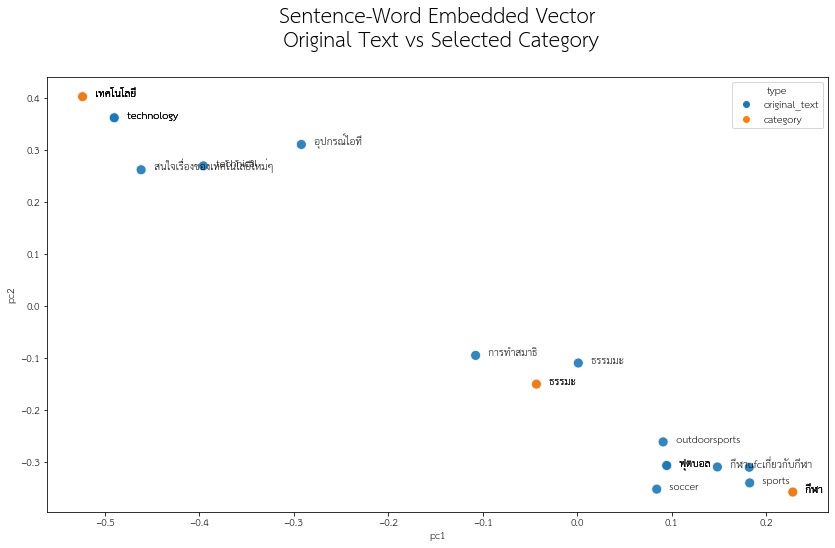

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
sns.scatterplot(x='pc1', y='pc2', data = df_pca2, hue = 'type', s = 100, alpha = 0.9)

for i in range(len(df_pca2)):
  label = df_pca2.loc[i, 'text']
  pc1 = df_pca2.loc[i, 'pc1']
  pc2 = df_pca2.loc[i, 'pc2']
  ax.annotate(f' {label}', xy = (pc1+0.01, pc2))

plt.title('Sentence-Word Embedded Vector\n Original Text vs Selected Category\n', size = 20)
plt.show()

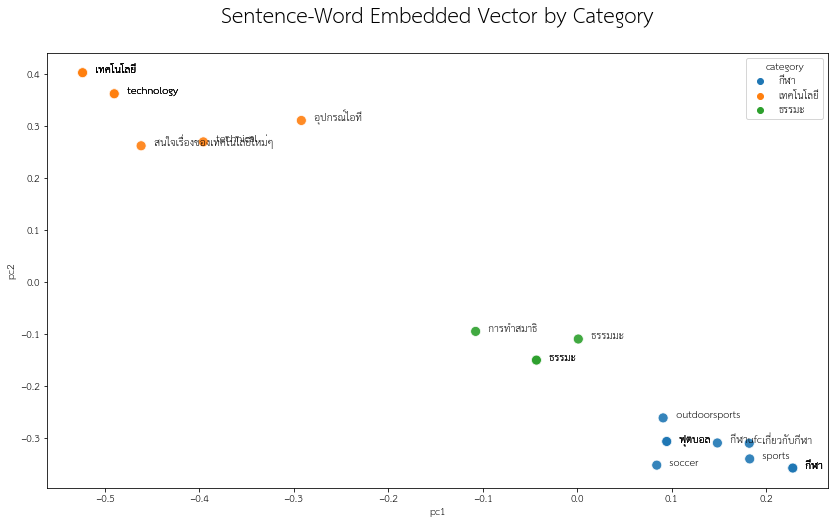

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))
sns.scatterplot(x='pc1', y='pc2', data = df_pca2, hue = 'category', s = 100, alpha =0.9)

for i in range(len(df_pca2)):
  label = df_pca2.loc[i, 'text']
  pc1 = df_pca2.loc[i, 'pc1']
  pc2 = df_pca2.loc[i, 'pc2']
  ax.annotate(f' {label}', xy = (pc1+0.01, pc2))

plt.title('Sentence-Word Embedded Vector by Category\n', size = 20)
plt.show()